# 8. Putting it all together with multi-class classification problem

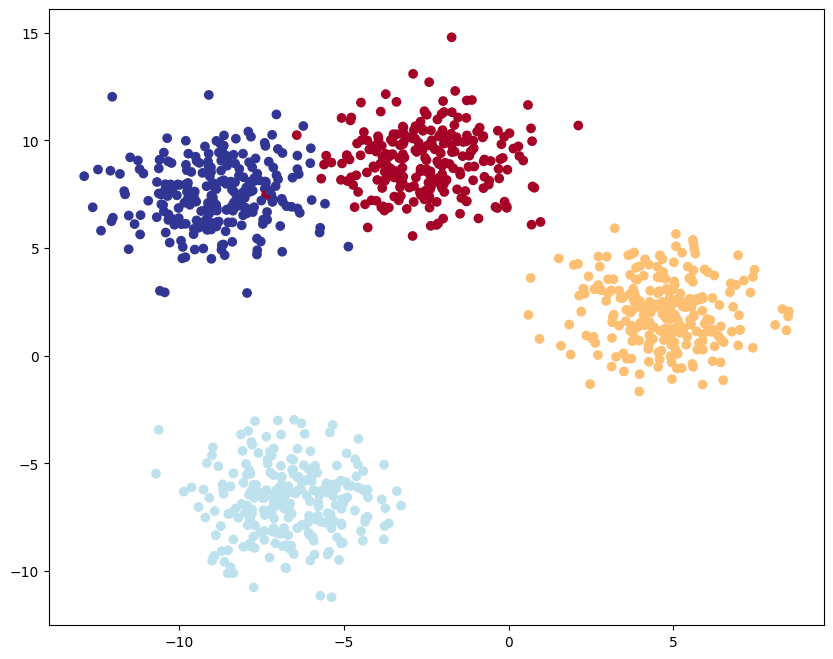

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, TensorDataset

# hyperparameters
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# set device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.__version__, device

# 1. Create multi-class data
X_blob, y_blob = make_blobs(
    n_samples=1000,
    n_features=NUM_FEATURES,
    centers=NUM_CLASSES,
    cluster_std=1.5,
    random_state=RANDOM_SEED,
)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.float)

# 3. Split Data
X_train, X_test, y_train, y_test = train_test_split(
    X_blob, y_blob, test_size=0.2, train_size=0.8, random_state=RANDOM_SEED
)

# 4. Plot Data
plt.figure(figsize=(10, 8))
plt.scatter(x=X_blob[:, 0], y=X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

In [320]:
X_blob.shape

torch.Size([1000, 2])

## Model

In [4]:
class BlobClassificationModel(torch.nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

        self.layer_0 = torch.nn.Linear(in_features=2, out_features=8)
        self.layer_1 = torch.nn.Linear(in_features=8, out_features=16)
        self.layer_2 = torch.nn.Linear(in_features=16, out_features=8)
        self.layer_3 = torch.nn.Linear(in_features=8, out_features=4)

        self.activation_relu = torch.nn.ReLU()

    def forward(self, x):
        return self.layer_3(
            self.activation_relu(
                self.layer_2(
                    self.activation_relu(
                        self.layer_1(self.activation_relu(self.layer_0(x)))
                    )
                )
            )
        )


model_00 = BlobClassificationModel().to(device)

In [7]:
optimizer = torch.optim.Adam(params=model_00.parameters(), lr=0.01)
loss_fn = torch.nn.CrossEntropyLoss()

## Training

### Data preparation

In [6]:
# moving data to device and dividing it into batches
X_train, X_test, y_train, y_test = (
    X_train.to(device).to(torch.float32).squeeze(),
    X_test.to(device).to(torch.float32).squeeze(),
    y_train.to(device).to(torch.float32).squeeze().long(),
    y_test.to(device).to(torch.float32).squeeze().long(),
)

# Create TensorDataset
train_dataset = TensorDataset(X_train, y_train)

# Define batch size
batch_size = 32

# Create DataLoader for batching
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)


### Training and testing loop

In [8]:
epochs = 5
torch.manual_seed(42)
torch.cuda.manual_seed(42)

for epoch in range(epochs):
    # Training loop
    model_00.train()
    for X_batch, y_batch in train_loader:
        logits = model_00(X_batch).type(torch.float)
        loss = loss_fn(logits, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Testing loop
    model_00.eval()
    with torch.inference_mode():
        test_logits = model_00(X_test)
        test_loss = loss_fn(test_logits, y_test)
        probabilities = torch.softmax(test_logits, dim=1)
        predictions = torch.argmax(probabilities, dim=1)
        accuracy = accuracy_score(y_true=y_test.to('cpu'), y_pred=predictions.to('cpu'))
        print(f"Epoch: {epoch+1}, accuracy: {accuracy}, loss: {test_loss}")
        

Epoch: 1, accuracy: 0.71, loss: 0.6621245741844177
Epoch: 2, accuracy: 0.97, loss: 0.3394301235675812
Epoch: 3, accuracy: 0.995, loss: 0.25108715891838074
Epoch: 4, accuracy: 0.995, loss: 0.19231940805912018
Epoch: 5, accuracy: 0.995, loss: 0.14806634187698364


# Predictions, evaluation and visualization

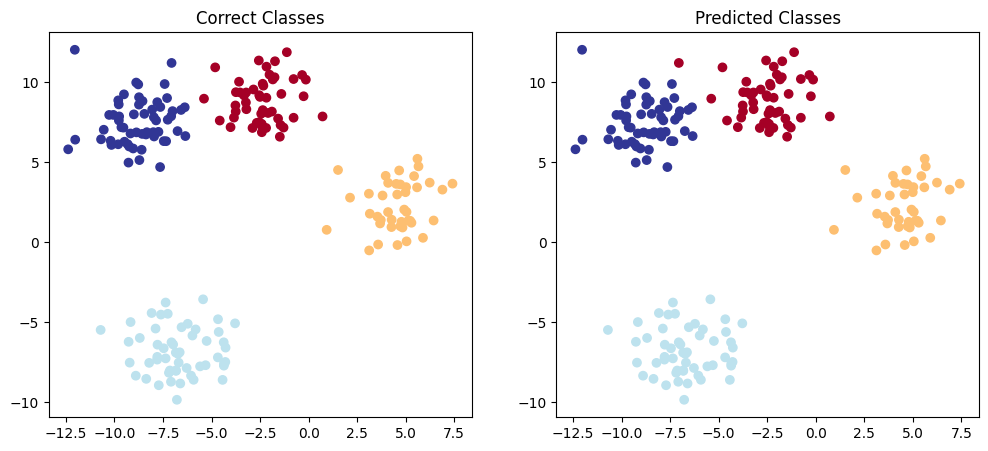

In [9]:
correct_values = y_test
predictions = None

model_00.eval()
with torch.inference_mode():
    test_logits = model_00(X_test)
    test_loss = loss_fn(test_logits, y_test)
    probabilities = torch.softmax(test_logits, dim=1)
    predictions = torch.argmax(probabilities, dim=1)
    
    
# Convert tensors to numpy arrays
correct_values_np = correct_values.cpu().numpy()
predictions_np = predictions.cpu().numpy()

# 4. Plot Data
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title("Correct Classes")
plt.scatter(x=X_test.cpu()[:, 0], y=X_test.cpu()[:, 1], c=correct_values_np, cmap=plt.cm.RdYlBu)
plt.subplot(1, 2, 2)
plt.title("Predicted Classes")
plt.scatter(x=X_test.cpu()[:, 0], y=X_test.cpu()[:, 1], c=predictions_np, cmap=plt.cm.RdYlBu)